In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('MBB Historical Data.csv')
df1=df.reset_index()['Price']

In [3]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [4]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [5]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = len(df1)-train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [6]:
# 5. Create Dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


In [7]:
# 6. Reshape Input to Fit RNN
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [8]:
# 7. Define RNN Model
model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [9]:
# 8. Fit Model with Training Data
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100

15/15 [==============================] - 1s 9ms/step - loss: 0.1254
Epoch 2/100
15/15 [==============================] - 0s 9ms/step - loss: 0.0116
Epoch 3/100
15/15 [==============================] - 0s 9ms/step - loss: 0.0032
Epoch 4/100
15/15 [==============================] - 0s 10ms/step - loss: 0.0023
Epoch 5/100
15/15 [==============================] - 0s 10ms/step - loss: 0.0019
Epoch 6/100
15/15 [==============================] - 0s 10ms/step - loss: 0.0018
Epoch 7/100
15/15 [==============================] - 0s 10ms/step - loss: 0.0017
Epoch 8/100
15/15 [==============================] - 0s 9ms/step - loss: 0.0016
Epoch 9/100
15/15 [==============================] - 0s 9ms/step - loss: 0.0016
Epoch 10/100
15/15 [==============================] - 0s 9ms/step - loss: 0.0015
Epoch 11/100
15/15 [==============================] - 0s 9ms/step - loss: 0.0016
Epoch 12/100
15/15 [==============================] - 0s 9ms/step - loss: 0.0013
Epoch 13/100
15/15 [============

15/15 [==============================] - 0s 13ms/step - loss: 5.1810e-04
Epoch 96/100
15/15 [==============================] - 0s 12ms/step - loss: 5.1008e-04
Epoch 97/100
15/15 [==============================] - 0s 12ms/step - loss: 5.1823e-04
Epoch 98/100
15/15 [==============================] - 0s 15ms/step - loss: 4.9956e-04
Epoch 99/100
15/15 [==============================] - 0s 13ms/step - loss: 4.9579e-04
Epoch 100/100
15/15 [==============================] - 0s 13ms/step - loss: 5.3758e-04


In [10]:
# 9. Make Predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

5/5 [==============================] - 0s 5ms/step


In [11]:
# 10. Inverse Transform Predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [12]:
# 11. Evaluate Model with RMSE
test_rmse = np.sqrt(np.mean((test_predict - scaler.inverse_transform(y_test.reshape(-1, 1))) ** 2))
print('Testing RMSE:', test_rmse)

Testing RMSE: 530.8548124641939


In [13]:
# 12. Forecast Next 30 Days
last_input = test_data[-time_step:].reshape(1, -1)
temp_input = list(last_input)
temp_input = temp_input[0].tolist()

lst_output = []
i = 0
while i < 30:
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1,100, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = last_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Inverse transform the actual test labels
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Compute RMSE
test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_predict))
print('Testing RMSE:', test_rmse)

# Compute MAE
test_mae = mean_absolute_error(y_test_actual, test_predict)
print('Testing MAE:', test_mae)

# Compute MAPE
test_mape = mean_absolute_percentage_error(y_test_actual, test_predict)
print('Testing MAPE:', test_mape)

Testing RMSE: 530.8548124641939
Testing MAE: 390.60460885067204
Testing MAPE: 2.09960852677472


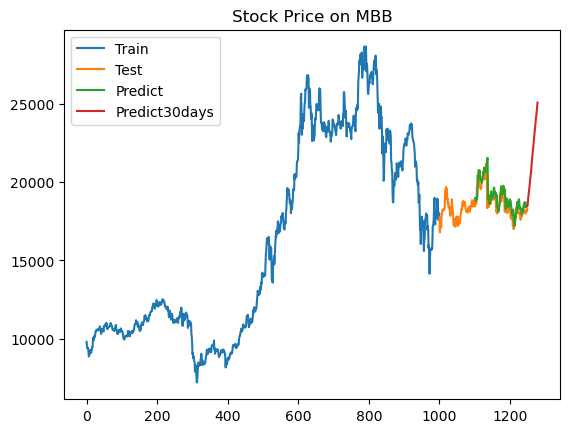

In [16]:
# Step 12: Plot Results with Train and Test Predictions

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(test_predict))
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.title('Stock Price on MBB')
plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()